### 1. 文本清晰度改进尝试

[[0 1 0]
 [1 1 1]
 [0 1 0]]


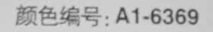

[[94, '颜'], [96, '色'], [73, '缉'], [96, '号'], [89, ':'], [83, 'A1-6369']]


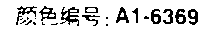

[[54, '颠'], [85, '色'], [51, '编'], [96, '号'], [83, ':'], [61, 'A1-6369']]


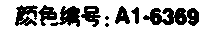

[[59, '颖'], [93, '色'], [67, '编'], [96, '号'], [89, ':'], [75, 'A1.6369']]


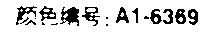

[[51, '阮'], [71, '色'], [70, '编'], [96, '号'], [80, ':'], [82, 'A1-6369']]


In [109]:
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from glob import glob
import pytesseract

def text_recognition(img):
    conf = '-l chi_sim --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0'
    df = pytesseract.image_to_data(img, output_type=pytesseract.Output.DATAFRAME, config=conf)
    df = df[df.conf>0][['conf', 'text']]
    return df.to_dict('split').get('data')
    

# import cv2.cv as cv
# /Users/liuliangjun/Downloads/test6.png
# ./images/test5.png
img = cv2.imread('./images/test5.png')  #  test4 test1 test5
img = cv2.resize(img, (213, 32))
GrayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二值化  
# 模式 THRESH_BINARY THRESH_TRUNC THRESH_TOZERO
ret, thresh1 = cv2.threshold(GrayImage, 150, 255, cv2.THRESH_BINARY)  
# ret,thresh2=cv2.threshold(GrayImage,130,255,cv2.THRESH_BINARY_INV)

# 定义卷积核
kernel = np.uint8(np.zeros((3, 3)))
kernel[1][1] = 1
kernel[0][1] = 1
kernel[1][0] = 1
kernel[1][2] = 1
kernel[2][1] = 1

# for x in range(3):
#     kernel[x, 2] = 1
#     kernel[2, x] = 1
print(kernel)

# 原图
display(Image.fromarray(GrayImage))
print(text_recognition(GrayImage))

# 二值化
display(Image.fromarray(thresh1))
print(text_recognition(thresh1))

# 腐蚀图像
eroded = cv2.erode(thresh1, kernel)
display(Image.fromarray(eroded))
print(text_recognition(eroded))

# 膨胀图像
dilated = cv2.dilate(eroded, kernel)
display(Image.fromarray(dilated))
print(text_recognition(dilated))


#### 结论： 识别结果的正确与否 非常依赖二值化的时候设置的阈值，很难具有普遍适用性
#### tesseract 对图像噪音也有不错的适应性

#### 图片大小对识别结果也有影响  图片太大会影响质量 建议缩小为高为32的

./images/13.png


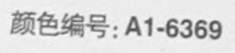

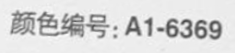

[[95, '颜'], [96, '色'], [88, '缉'], [93, '号'], [92, ':'], [92, 'A1-6369']]


In [49]:

paths = glob('./images/*_.png')

def process_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     display(img)
    
    arr = (img // 10)*10 
    counts = np.bincount(arr.flatten())
#     print(np.argmax(counts))
    
    display(Image.fromarray(img))
    
    # threshold
#     ret, thresh1 = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)
#     ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
    
    # 对比度图像增强法
#     new_arr = thresh1*2
    
    img = Image.fromarray(img)
    display(img.convert('RGB'))
    return img

for p in paths:
    p = './images/13.png'
    print(p)
    image = process_img(p)
    df = pytesseract.image_to_data(image, output_type=pytesseract.Output.DATAFRAME, config='-l chi_sim --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')

    df = df[df.conf>0][['conf', 'text']]
    print(df.to_dict('split').get('data'))
    break

### 2. 图片水平矫正方法一  (图像旋转方式矫正)

-2.7927021980285645


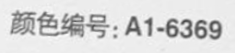

[[95, '颜'], [96, '色'], [88, '缉'], [93, '号'], [92, ':'], [92, 'A1-6369']]


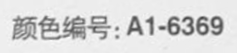

[[95, '颜'], [96, '色'], [84, '编'], [93, '号'], [92, ':'], [90, 'A1-6369']]


In [97]:
# 图片旋转
import math
def rotate_bound(image, angle):
    # angle 处理
    if angle < -60:
        angle = np.abs(angle) - 90
    elif angle > 60:
        angle = 90 - angle
    
    #获取宽高
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # 提取旋转矩阵 sin cos 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # 计算图像的新边界尺寸
    nW = int((h * sin) + (w * cos))
    nH = h
 
    # 调整旋转矩阵
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv2.warpAffine(image, M, (nW, nH),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


# 获取图片旋转角度
def get_minAreaRect(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 127, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    return cv2.minAreaRect(coords)[-1]
 
image_path = './images/test4.png'  
image = cv2.imread(image_path)
angle = get_minAreaRect(image)
rotated = rotate_bound(image, angle)

print(angle)
display(Image.fromarray(image))
print(text_recognition(image))
display(Image.fromarray(rotated))
print(text_recognition(rotated))

#### 文本水平矫正后，有效提高识别率

In [ ]:
# 以 ~ | — _ 空格 开头结尾的都可以去除
# adjust调整False，然后扩展两个像素点
?Image.fromarray

### 3. 直线检测 抹去干扰线

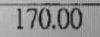

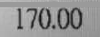

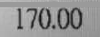

In [8]:
# left 不为-1的拼接，特殊符号去空格，单词之间空格连接
# 直线检测

import cv2 as cv
import numpy as np


def line_detect_possible(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, 50, 100, apertureSize = 3)
    # minLineLength - 线段的最小长度. Line segments shorter than this are rejected.
    # maxLineGap - 使程序识别线段为一条线的线段之间最大的空隙
    lines = cv.HoughLinesP(edges, 1, np.pi/180, 50, 100, minLineLength = 50, maxLineGap = 1)
    if lines is None:
        return 
    
    h, w, _ = image.shape
    
    # 填充颜色计算
    arr = image.flatten()
    arr = [i for i in arr if i >= 80] # 灰度大于80的才计算（太黑的就是字体颜色了）
    gray = sum(arr) / max(len(arr), 1) # 避免除0报错
    
    for line in lines:
        x1, y1, x2, y2 = line[0] 
        # 只处理水平线，避免识别错误线段必须大于长度的三分一以上
        if (y2 - y1) > (x2 - x1) or (x2 - x1) < w/3:
            continue
        
        # 画线条
        #cv.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        # 整条水平线都画颜色
        cv.line(image, (0, y1), (w, y2), (gray, gray, gray), 2)
    
    img = Image.fromarray(image)
    display(img)
    return img

src = cv.imread("./images/17_.png")
display(Image.fromarray(src))
line_detect_possible(src)

src = cv.imread("./images/27_.png")
display(Image.fromarray(src))
line_detect_possible(src)

# 只处理水平干扰线（需要判断是否为水平）
# 占长度的60%以上 才算干扰线
# 高斯填充

In [ ]:
for p in paths:
    src = cv.imread(p)
    
    display(Image.fromarray(src))
    df1 = pytesseract.image_to_data(src, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
    print(df1[df1.conf>0][['conf', 'text']])
    
    image = line_detect_possible(src)
    
    if image is not None:
        print(p)
        df = pytesseract.image_to_data(image, output_type=pytesseract.Output.DATAFRAME, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
        print(df[df.conf>0][['conf', 'text']])

### 去除印章

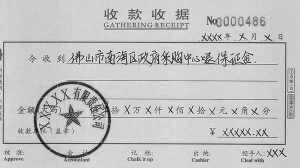

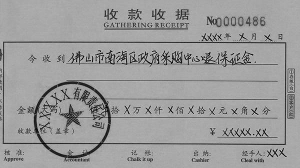

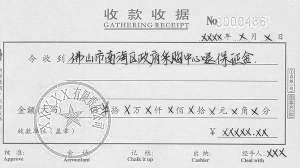

In [98]:
#去除印章
import cv2
import numpy as np
import matplotlib.pyplot as plt


image0=cv2.imread("/Users/liuliangjun/Downloads/test17.jpg",cv2.IMREAD_COLOR)   # 以BGR色彩读取图片
image = cv2.resize(image0,None,fx=0.5,fy=0.5,
                   interpolation=cv2.INTER_CUBIC)  # 缩小图片0.5倍（图片太大了）
cols,rows,_=image.shape                            # 获取图片高宽
B_channel,G_channel,R_channel=cv2.split(image)     # 注意cv2.split()返回通道顺序

display(Image.fromarray(B_channel))
display(Image.fromarray(G_channel))
display(Image.fromarray(R_channel))

In [101]:
560 / (84/32)

213.33333333333334